In [44]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from collections import Counter
import math
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import random as python_random
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Why BNN?

In [45]:
# some helper functions for Deep Ensembles
def nll1(y_true, y_pred):
    """ Negative log likelihood. """
    y_true = tf.cast(y_true, dtype=tf.float32)
    # keras.losses.binary_crossentropy give the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

def train(xtrain, ytrain, batch, epochs, validation_data=None):
        h = []
        models = []
        # Train 10 models
        for i in tqdm(range(10)):
            # Get model
            models.append(base_model())
            # Train model
            h1=models[i].fit(xtrain, ytrain, batch_size=batch,  epochs=epochs,verbose=0)
            h.append(h1)
        return h, models

def base_model():
    model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss=nll1,metrics=["accuracy"])
    return model

def model_eval(X,Y,classifiers):
    loss = []
    acc = []
    for each_model in classifiers:
        test_results = each_model.evaluate(X,Y)
        print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
        loss.append(test_results[0])
        acc.append(test_results[1])
    print("######################################################")
    print(f' Loss    : {np.mean(loss)} - {np.std(loss)}')
    print(f' Accuracy: {np.mean(acc)} - {np.std(acc)}%')
    return loss,acc

def underestimation_score_1(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',1)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',1)


    if P_FX0 == 0:
        print("Divsion by zero detected: denom is ",P_FX0)
        return 0.000001
    print(P_dash_FX0,P_FX0)
    return P_dash_FX0/P_FX0

def underestimation_score(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    if P_FX0 == 0:
        print("Divsion by zero detected: denom is ",P_FX0)
        return 0.000001
    print(P_dash_FX0,P_FX0)
    return P_dash_FX0/P_FX0

def UEI(sa, Y_train, Y_pred):
    us_df = {}
    us_df['sa'] = sa
    us_df['ytrain_actual'] = Y_train
    us_df['ytest_pred'] = Y_pred
    us_df = pd.DataFrame(us_df)

    prob_array = []
    for y in (0,1):
        for s in (0,1):
#             print((y,s))
            p_tilda = df_count_feat_val_match(us_df, 'ytrain_actual', y, 'sa',s)/len(us_df)
            p_hat = df_count_feat_val_match(us_df, 'ytest_pred', y, 'sa',s)/len(us_df)
#             print(p_hat,p_tilda)
            prob_array.append(   np.square(np.sqrt(p_hat)-np.sqrt(p_tilda))    )
    return np.sqrt(0.5*np.sum(prob_array))

def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

import os
import math
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from typing import Dict, List, Tuple, Optional
from sklearn.utils import check_consistent_length, column_or_1d
from sklearn.calibration import calibration_curve


__all__ = [
    'compute_calibration_error',
    'create_binned_data',
    'get_bin_boundaries',
    'compute_binary_score',
    'compute_calibration_summary',
]


def compute_calibration_error(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int=15,
    round_digits: int=4) -> float:
    """
    Computes the calibration error for binary classification via binning
    data points into the specified number of bins. Samples with similar
    ``y_prob`` will be grouped into the same bin. The bin boundary is
    determined by having similar number of samples within each bin.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.

    round_digits : int, default 4
        Round the calibration error metric.

    Returns
    -------
    calibration_error : float
        RMSE between the average positive label and predicted probability
        within each bin.
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, n_bins)

    # looping shouldn't be a source of bottleneck as n_bins should be a small number.
    bin_errors = 0.0
    for bin_y_true, bin_y_prob in zip(binned_y_true, binned_y_prob):
        avg_y_true = np.mean(bin_y_true)
        avg_y_score = np.mean(bin_y_prob)
        bin_error = (avg_y_score - avg_y_true) ** 2
        bin_errors += bin_error * len(bin_y_true)

    calibration_error = math.sqrt(bin_errors / len(y_true))
    return round(calibration_error, round_digits)


def create_binned_data(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Bin ``y_true`` and ``y_prob`` by distribution of the data.
    i.e. each bin will contain approximately an equal number of
    data points. Bins are sorted based on ascending order of ``y_prob``.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data.

    Returns
    -------
    binned_y_true/binned_y_prob : 1d ndarray
        Each element in the list stores the data for that bin.
    """
    sorted_indices = np.argsort(y_prob)
    sorted_y_true = y_true[sorted_indices]
    sorted_y_prob = y_prob[sorted_indices]
    binned_y_true = np.array_split(sorted_y_true, n_bins)
    binned_y_prob = np.array_split(sorted_y_prob, n_bins)
    return binned_y_true, binned_y_prob


def get_bin_boundaries(binned_y_prob: List[np.ndarray]) -> np.ndarray:
    """
    Given ``binned_y_prob`` from ``create_binned_data`` get the
    boundaries for each bin.

    Parameters
    ----------
    binned_y_prob : list
        Each element in the list stores the data for that bin.

    Returns
    -------
    bins : 1d ndarray
        Boundaries for each bin.
    """
    bins = []
    for i in range(len(binned_y_prob) - 1):
        last_prob = binned_y_prob[i][-1]
        next_first_prob = binned_y_prob[i + 1][0]
        bins.append((last_prob + next_first_prob) / 2.0)

    bins.append(1.0)
    return np.array(bins)


def compute_binary_score(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    round_digits: int=4) -> Dict[str, float]:
    """
    Compute various evaluation metrics for binary classification.
    Including auc, precision, recall, f1, log loss, brier score. The
    threshold for precision and recall numbers are based on the one
    that gives the best f1 score.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    round_digits : int, default 4
        Round the evaluation metric.

    Returns
    -------
    metrics_dict : dict
        Metrics are stored in key value pair. ::

        {
            'auc': 0.82,
            'precision': 0.56,
            'recall': 0.61,
            'f1': 0.59,
            'log_loss': 0.42,
            'brier': 0.12
        }
    """
    auc = round(metrics.roc_auc_score(y_true, y_prob), round_digits)
    log_loss = round(metrics.log_loss(y_true, y_prob), round_digits)
    brier_score = round(metrics.brier_score_loss(y_true, y_prob), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_prob)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss,
        'brier': brier_score
    }


def compute_calibration_summary(
    eval_dict: Dict[str, pd.DataFrame],
    label_col: str='label',
    score_col: str='score',
    n_bins: int=15,
    strategy: str='quantile',
    round_digits: int=4,
    show: bool=True,
    save_plot_path: Optional[str]=None) -> pd.DataFrame:
    """
    Plots the calibration curve and computes the summary statistics for the model.

    Parameters
    ----------
    eval_dict : dict
        We can evaluate multiple calibration model's performance in one go. The key
        is the model name used to distinguish different calibration model, the value
        is the dataframe that stores the binary true targets and the predicted score
        for the positive class.

    label_col : str
        Column name for the dataframe in ``eval_dict`` that stores the binary true targets.

    score_col : str
        Column name for the dataframe in ``eval_dict`` that stores the predicted score.

    n_bins : int, default 15
        Number of bins to discretize the calibration curve plot and calibration error statistics.
        A bigger number requires more data, but will be closer to the true calibration error.

    strategy : {'uniform', 'quantile'}, default 'quantile'
        Strategy used to define the boundary of the bins.

        - uniform: The bins have identical widths.
        - quantile: The bins have the same number of samples and depend on the predicted score.

    round_digits : default 4
        Round the evaluation metric.

    show : bool, default True
        Whether to show the plots on the console or jupyter notebook.

    save_plot_path : str, default None
        Path where we'll store the calibration plot. None means it will not save the plot.

    Returns
    -------
    df_metrics : pd.DataFrame
        Corresponding metrics for all the input dataframe.
    """

    fig, (ax1, ax2) = plt.subplots(2)

    # estimator_metrics stores list of dict, e.g.
    # [{'auc': 0.776, 'name': 'xgb'}]
    estimator_metrics = []
    for name, df_eval in eval_dict.items():
        prob_true, prob_pred = calibration_curve(
            df_eval[label_col],
            df_eval[score_col],
            n_bins=n_bins,
            strategy=strategy)

        calibration_error = compute_calibration_error(
            df_eval[label_col], df_eval[score_col], n_bins, round_digits)
        metrics_dict = compute_binary_score(df_eval[label_col], df_eval[score_col], round_digits)
        metrics_dict['calibration_error'] = calibration_error
        metrics_dict['name'] = name
        estimator_metrics.append(metrics_dict)

        ax1.plot(prob_pred, prob_true, 's-', label=name)
        ax2.hist(df_eval[score_col], range=(0, 1), bins=n_bins, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='perfect')

    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='upper left', ncol=2)
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper right', ncol=2)

    plt.tight_layout()
    if show:
        plt.show()

    if save_plot_path is not None:
        save_dir = os.path.dirname(save_plot_path)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        fig.savefig(save_plot_path, dpi=300, bbox_inches='tight')

    plt.close(fig)

    df_metrics = pd.DataFrame(estimator_metrics)
    return df_metrics


def underestimation_score_1(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',1)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',1)


    if P_FX0 == 0:
        print("Divsion by zero detected: denom is ",P_FX0)
        return 0.000001
    print(P_dash_FX0,P_FX0)
    return P_dash_FX0/P_FX0

def underestimation_score(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    if P_FX0 == 0:
        print("Divsion by zero detected: denom is ",P_FX0)
        return 0.000001
    print(P_dash_FX0,P_FX0)
    return P_dash_FX0/P_FX0

def UEI(sa, Y_train, Y_pred):
    us_df = {}
    us_df['sa'] = sa
    us_df['ytrain_actual'] = Y_train
    us_df['ytest_pred'] = Y_pred
    us_df = pd.DataFrame(us_df)

    prob_array = []
    for y in (0,1):
        for s in (0,1):
#             print((y,s))
            p_tilda = df_count_feat_val_match(us_df, 'ytrain_actual', y, 'sa',s)/len(us_df)
            p_hat = df_count_feat_val_match(us_df, 'ytest_pred', y, 'sa',s)/len(us_df)
#             print(p_hat,p_tilda)
            prob_array.append(   np.square(np.sqrt(p_hat)-np.sqrt(p_tilda))    )
    return np.sqrt(0.5*np.sum(prob_array))

def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])


import os
import math
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from typing import Dict, List, Tuple, Optional
from sklearn.utils import check_consistent_length, column_or_1d
from sklearn.calibration import calibration_curve


__all__ = [
    'compute_calibration_error',
    'create_binned_data',
    'get_bin_boundaries',
    'compute_binary_score',
    'compute_calibration_summary',
]


def compute_calibration_error(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int=15,
    round_digits: int=4) -> float:
    """
    Computes the calibration error for binary classification via binning
    data points into the specified number of bins. Samples with similar
    ``y_prob`` will be grouped into the same bin. The bin boundary is
    determined by having similar number of samples within each bin.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.

    round_digits : int, default 4
        Round the calibration error metric.

    Returns
    -------
    calibration_error : float
        RMSE between the average positive label and predicted probability
        within each bin.
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, n_bins)

    # looping shouldn't be a source of bottleneck as n_bins should be a small number.
    bin_errors = 0.0
    for bin_y_true, bin_y_prob in zip(binned_y_true, binned_y_prob):
        avg_y_true = np.mean(bin_y_true)
        avg_y_score = np.mean(bin_y_prob)
        bin_error = (avg_y_score - avg_y_true) ** 2
        bin_errors += bin_error * len(bin_y_true)

    calibration_error = math.sqrt(bin_errors / len(y_true))
    return round(calibration_error, round_digits)


def create_binned_data(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Bin ``y_true`` and ``y_prob`` by distribution of the data.
    i.e. each bin will contain approximately an equal number of
    data points. Bins are sorted based on ascending order of ``y_prob``.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data.

    Returns
    -------
    binned_y_true/binned_y_prob : 1d ndarray
        Each element in the list stores the data for that bin.
    """
    sorted_indices = np.argsort(y_prob)
    sorted_y_true = y_true[sorted_indices]
    sorted_y_prob = y_prob[sorted_indices]
    binned_y_true = np.array_split(sorted_y_true, n_bins)
    binned_y_prob = np.array_split(sorted_y_prob, n_bins)
    return binned_y_true, binned_y_prob


def get_bin_boundaries(binned_y_prob: List[np.ndarray]) -> np.ndarray:
    """
    Given ``binned_y_prob`` from ``create_binned_data`` get the
    boundaries for each bin.

    Parameters
    ----------
    binned_y_prob : list
        Each element in the list stores the data for that bin.

    Returns
    -------
    bins : 1d ndarray
        Boundaries for each bin.
    """
    bins = []
    for i in range(len(binned_y_prob) - 1):
        last_prob = binned_y_prob[i][-1]
        next_first_prob = binned_y_prob[i + 1][0]
        bins.append((last_prob + next_first_prob) / 2.0)

    bins.append(1.0)
    return np.array(bins)


def compute_binary_score(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    round_digits: int=4) -> Dict[str, float]:
    """
    Compute various evaluation metrics for binary classification.
    Including auc, precision, recall, f1, log loss, brier score. The
    threshold for precision and recall numbers are based on the one
    that gives the best f1 score.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    round_digits : int, default 4
        Round the evaluation metric.

    Returns
    -------
    metrics_dict : dict
        Metrics are stored in key value pair. ::

        {
            'auc': 0.82,
            'precision': 0.56,
            'recall': 0.61,
            'f1': 0.59,
            'log_loss': 0.42,
            'brier': 0.12
        }
    """
    auc = round(metrics.roc_auc_score(y_true, y_prob), round_digits)
    log_loss = round(metrics.log_loss(y_true, y_prob), round_digits)
    brier_score = round(metrics.brier_score_loss(y_true, y_prob), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_prob)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss,
        'brier': brier_score
    }


def compute_calibration_summary(
    eval_dict: Dict[str, pd.DataFrame],
    label_col: str='label',
    score_col: str='score',
    n_bins: int=15,
    strategy: str='quantile',
    round_digits: int=4,
    show: bool=True,
    save_plot_path: Optional[str]=None) -> pd.DataFrame:
    """
    Plots the calibration curve and computes the summary statistics for the model.

    Parameters
    ----------
    eval_dict : dict
        We can evaluate multiple calibration model's performance in one go. The key
        is the model name used to distinguish different calibration model, the value
        is the dataframe that stores the binary true targets and the predicted score
        for the positive class.

    label_col : str
        Column name for the dataframe in ``eval_dict`` that stores the binary true targets.

    score_col : str
        Column name for the dataframe in ``eval_dict`` that stores the predicted score.

    n_bins : int, default 15
        Number of bins to discretize the calibration curve plot and calibration error statistics.
        A bigger number requires more data, but will be closer to the true calibration error.

    strategy : {'uniform', 'quantile'}, default 'quantile'
        Strategy used to define the boundary of the bins.

        - uniform: The bins have identical widths.
        - quantile: The bins have the same number of samples and depend on the predicted score.

    round_digits : default 4
        Round the evaluation metric.

    show : bool, default True
        Whether to show the plots on the console or jupyter notebook.

    save_plot_path : str, default None
        Path where we'll store the calibration plot. None means it will not save the plot.

    Returns
    -------
    df_metrics : pd.DataFrame
        Corresponding metrics for all the input dataframe.
    """

    fig, (ax1, ax2) = plt.subplots(2)

    # estimator_metrics stores list of dict, e.g.
    # [{'auc': 0.776, 'name': 'xgb'}]
    estimator_metrics = []
    for name, df_eval in eval_dict.items():
        prob_true, prob_pred = calibration_curve(
            df_eval[label_col],
            df_eval[score_col],
            n_bins=n_bins,
            strategy=strategy)

        calibration_error = compute_calibration_error(
            df_eval[label_col], df_eval[score_col], n_bins, round_digits)
        metrics_dict = compute_binary_score(df_eval[label_col], df_eval[score_col], round_digits)
        metrics_dict['calibration_error'] = calibration_error
        metrics_dict['name'] = name
        estimator_metrics.append(metrics_dict)

        ax1.plot(prob_pred, prob_true, 's-', label=name)
        ax2.hist(df_eval[score_col], range=(0, 1), bins=n_bins, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='perfect')

    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='upper left', ncol=2)
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper right', ncol=2)

    plt.tight_layout()
    if show:
        plt.show()

    if save_plot_path is not None:
        save_dir = os.path.dirname(save_plot_path)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        fig.savefig(save_plot_path, dpi=300, bbox_inches='tight')

    plt.close(fig)

    df_metrics = pd.DataFrame(estimator_metrics)
    return df_metrics

## Recidivism

In [49]:
## Recidivism Dataset
df = pd.read_csv("recidivism.csv")
df.pop('Unnamed: 0')
df.head()

y = df['Recid2Y'].values
df.pop('Recid2Y')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle = True, random_state=40, stratify = y)
Xtrain_num = X_train[['age','juv_fel_count','juv_misd_count','priors_count']]
x_train_cat = X_train[['Gender','Felony','Caucasian']]
Xtest_num = X_test[['age','juv_fel_count','juv_misd_count','priors_count']]
x_test_cat = X_test[['Gender','Felony','Caucasian']]

stdscl = StandardScaler()
Xtrain_num = stdscl.fit_transform(Xtrain_num)
Xtest_num = stdscl.transform(Xtest_num)

Xtrain = np.hstack((Xtrain_num,x_train_cat))
Xtest = np.hstack((Xtest_num,x_test_cat))

## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss=nll1,metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.27s/it]

 1/68 [..............................] - ETA: 10s - loss: 0.6139 - accuracy: 0.7188

68/68 [==============================] - 0s 1ms/step - loss: 0.6082 - accuracy: 0.6855
Test results - Loss: 0.6081584692001343 - Accuracy: 0.6854503750801086%
68/68 [==============================] - 0s 1ms/step - loss: 0.6055 - accuracy: 0.6905
Test results - Loss: 0.6055217981338501 - Accuracy: 0.6905311942100525%
68/68 [==============================] - 0s 1ms/step - loss: 0.6060 - accuracy: 0.6896
Test results - Loss: 0.6060453057289124 - Accuracy: 0.6896073818206787%
68/68 [==============================] - 0s 1ms/step - loss: 0.6064 - accuracy: 0.6887
Test results - Loss: 0.6064422130584717 - Accuracy: 0.6886836290359497%
68/68 [==============================] - 0s 1ms/step - loss: 0.6070 - accuracy: 0.6905
Test results - Loss: 0.6069598197937012 - Accuracy: 0.6905311942100525%
68/68 [==============================] - 0s 1ms/step - loss: 0.6095 - accuracy: 0.6864
Test results - Loss: 0.6094592809677124 - Accuracy: 0.6863741278648376%
68/68 [==============================] - 0s 1m

In [50]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

68/68 [==============================] - 0s 1ms/step - loss: 0.6083 - accuracy: 0.6831
Test results - Loss: 0.6083477735519409 - Accuracy: 0.6831408739089966%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0277
ECE_StandardNN   :  0.0513
UEI: 
UEI_DeepEnsembles:  0.06750998641992328
UEI_StandardNN   :  0.10452858128745272
US_0: 
172 270
US0_DeepEnsembles:  0.6370370370370371
139 270
US0_StandardNN   :  0.5148148148148148
US_1: 
631 706
US1_DeepEnsembles:  0.8937677053824362
549 706
US1_StandardNN   :  0.7776203966005666


In [55]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0287
ECE_DeepEnsembles_Min   :  0.0215
ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0584
ECE_DeepEnsembles_Min   :  0.0264


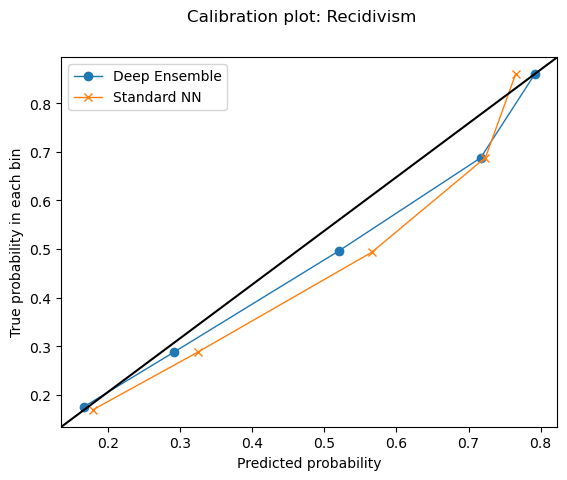

In [52]:
## Calibration plot for Deep Ensembles V.S Standard NN: we see that deep ensembles method gives more calibrated probability estimates

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(prob_true, prob_pred, marker='o', linewidth=1, label='Deep Ensemble')
plt.plot(prob_true_dnn, prob_pred_dnn, marker='x', linewidth=1, label='Standard NN')
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot: Recidivism')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.savefig("calib_plot_recid.png")
plt.show()

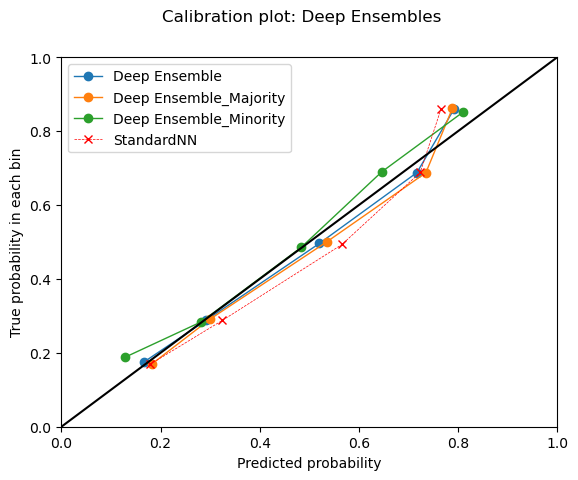

In [53]:
## Calibration plot for Deep Ensembles in terms of majority and minority group

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(prob_true, prob_pred, marker='o', linewidth=1, label='Deep Ensemble')
plt.plot(prob_true_maj, prob_pred_maj, marker='o', linewidth=1, label='Deep Ensemble_Majority')
plt.plot(prob_true_min, prob_pred_min, marker='o', linewidth=1, label='Deep Ensemble_Minority')
plt.plot(prob_true_dnn, prob_pred_dnn, marker='x', linewidth=0.5, linestyle = "--", color='red',label='StandardNN')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot: Deep Ensembles')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.legend()
plt.savefig("calib_plot_recid.png")
plt.show()


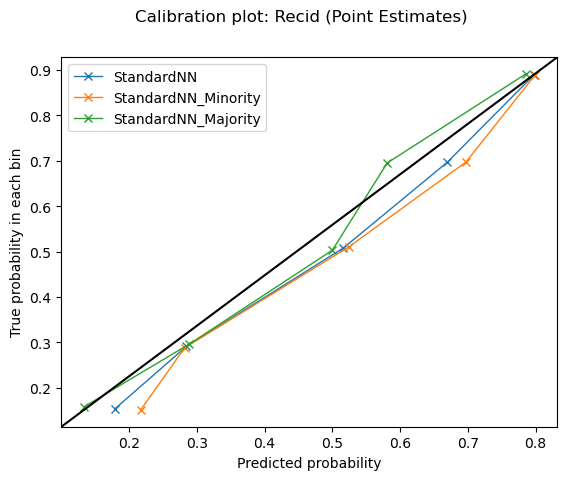

In [56]:
## Calibration plot for Standard NN in terms of majority and minority group

fig, ax = plt.subplots()
plt.plot(prob_true_dnn, prob_pred_dnn, marker='x', linewidth=1, label='StandardNN')
plt.plot(prob_true_dnn_maj, prob_pre_dnnd_maj, marker='x', linewidth=1, label='StandardNN_Minority')
plt.plot(prob_true_dnn_min, prob_pred_dnn_min, marker='x', linewidth=1, label='StandardNN_Majority')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot: Recid (Point Estimates)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

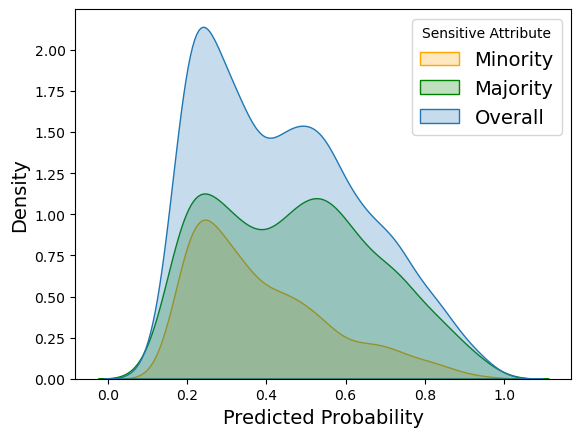

In [96]:
import seaborn as sns
c = {}
c['Predicted Probability'] = df['Ensembles']
c['sex'] = Xtest[:,-1]
c = pd.DataFrame(c)
sns.kdeplot(data=c,x='Predicted Probability',hue='sex',multiple='layer',legend=False,palette=["green", "orange"],shade=True)
sns.kdeplot(data=c,x='Predicted Probability',shade=True)
plt.legend(title='Sensitive Attribute', loc='upper right', labels=['Minority', 'Majority','Overall'],fontsize=14)
plt.xlabel('Predicted Probability', fontsize=14);
plt.ylabel('Density', fontsize=14);
# plt.title("PDF: Recidivism")
plt.savefig('kde.png', bbox_inches='tight')
plt.show()



In [56]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*truth
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.48484848484848486
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.4141414141414142
Train:
0.6777579718756189 0.5963468651744157 0.0052915163942326435
Test:
0.6803695150115473 0.6054995353998268 0.019269002068436177
US_S_0
659 706
0.93342776203966
US_S_1
263 270
0.9740740740740741


In [72]:
##Platt

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt = LogisticRegression(random_state=0)
platt.fit(y_preds_combined, y_train)
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt_probs = platt.predict_proba(y_preds_combined)[:,1]
print("Test:")
best_ba,best_us = evaluate(y_test,np.array(np.round(platt_probs)),Xtest[:,-1])
print(best_ba,nll1(y_test,np.array(tf.cast(platt_probs, dtype=tf.float32))).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,np.round(platt_probs),Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,np.round(platt_probs),Xtest[:,-1]))

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, platt_probs, n_bins=5)
df['Platt'] = platt_probs
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_Platt_All: ",compute_calibration_error(np.array(df.actual), df['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5))


Test:
0.6863741339491917 0.6030774686958719 0.061856008953863555
US_S_0
651 706
0.9220963172804533
US_S_1
176 270
0.6518518518518519
ECE with n_bins = 5:
ECE_Platt_All:  0.0261
ECE_Platt_Maj:  0.0219
ECE_Platt_Min   :  0.0265


## Adult

In [73]:
train_data =    pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
           names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
                    'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country',
                    'salary'])

test_data =    pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
          names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
                    'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country',
                    'salary'],
          skiprows = 1)

y_train = [1 if salary.strip() == ">50K" else 0 for salary in train_data['salary']]
y_test = [1 if salary.strip() == ">50K." else 0 for salary in test_data['salary']]
Xtest_num = test_data[['age', 'fnlwgt', 'education-num','capital-gain','capital-loss','hours-per-week']]

Xtrain_num = train_data[['age', 'fnlwgt', 'education-num','capital-gain','capital-loss','hours-per-week']]

stdscl = StandardScaler()
Xtrain_num = stdscl.fit_transform(Xtrain_num)
Xtest_num = stdscl.transform(Xtest_num)

x_test_cat = np.array([1 if gender.strip() == 'Male' else 0 for gender in test_data['sex']]).reshape(-1,1)
x_train_cat = np.array([1 if gender.strip() == 'Male' else 0 for gender in train_data['sex']]).reshape(-1,1)

Xtrain = np.hstack((Xtrain_num,x_train_cat))
Xtest = np.hstack((Xtest_num,x_test_cat))


In [84]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy",metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:57<00:00, 23.71s/it]

  1/509 [..............................] - ETA: 1:11 - loss: 0.2294 - accuracy: 0.9062

509/509 [==============================] - 1s 1ms/step - loss: 0.3621 - accuracy: 0.8358
Test results - Loss: 0.36214232444763184 - Accuracy: 0.8358209133148193%
509/509 [==============================] - 1s 1ms/step - loss: 0.3626 - accuracy: 0.8317
Test results - Loss: 0.36262184381484985 - Accuracy: 0.8317056894302368%
509/509 [==============================] - 1s 1ms/step - loss: 0.3638 - accuracy: 0.8342
Test results - Loss: 0.3637620806694031 - Accuracy: 0.8342239260673523%
509/509 [==============================] - 1s 1ms/step - loss: 0.3625 - accuracy: 0.8326
Test results - Loss: 0.36247265338897705 - Accuracy: 0.8325655460357666%
509/509 [==============================] - 1s 1ms/step - loss: 0.3620 - accuracy: 0.8340
Test results - Loss: 0.3620207607746124 - Accuracy: 0.8339782357215881%
509/509 [==============================] - 1s 1ms/step - loss: 0.3624 - accuracy: 0.8349
Test results - Loss: 0.36242160201072693 - Accuracy: 0.8348996043205261%
509/509 [=====================

In [85]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

509/509 [==============================] - 1s 1ms/step - loss: 0.3626 - accuracy: 0.8343
Test results - Loss: 0.3626038134098053 - Accuracy: 0.8343467712402344%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0106
ECE_StandardNN   :  0.0138
UEI: 
UEI_DeepEnsembles:  0.08144172025451543
UEI_StandardNN   :  0.08388944616383547
US_0: 
2382 3256
US0_DeepEnsembles:  0.7315724815724816
2318 3256
US0_StandardNN   :  0.711916461916462
US_1: 
183 590
US1_DeepEnsembles:  0.3101694915254237
185 590
US1_StandardNN   :  0.3135593220338983


In [93]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0084
ECE_DeepEnsembles_Min   :  0.0124
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0124
ECE_DNN_Min   :  0.0156


In [91]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.23232323232323235
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.393939393939394
Train:
0.8249132397653635 0.3509321926537883 0.0017438967309386843
Test:
0.8140777593513912 0.36074546250230327 0.004303563666249831
US_S_0
626 590
1.0610169491525423
US_S_1
3261 3256
1.0015356265356266


In [103]:
##Platt

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt = LogisticRegression(random_state=0,solver='lbfgs')
platt.fit(y_preds_combined, y_train)
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt_probs = platt.predict_proba(y_preds_combined)[:,1]
print("Test:")
best_ba,best_us = evaluate(y_test,np.array(np.round(platt_probs)),Xtest[:,-1])
print(best_ba,nll1(y_test,np.array(tf.cast(platt_probs, dtype=tf.float32))).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,np.round(platt_probs),Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,np.round(platt_probs),Xtest[:,-1]))

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, platt_probs, n_bins=5)
df['Platt'] = platt_probs
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_Platt_All: ",compute_calibration_error(np.array(df.actual), df['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5))


Test:
0.8348381549044899 0.37539749890593327 0.07408015801446045
US_S_0
194 590
0.3288135593220339
US_S_1
2523 3256
0.7748771498771498
ECE with n_bins = 5:
ECE_Platt_All:  0.0463
ECE_Platt_Maj:  0.0355
ECE_Platt_Min   :  0.0453


# Synthetic

In [112]:
## Synthetic Dataset
synthetic = pd.read_csv("synthetic.csv")
synthetic['admit'] = [0 if x == False else 1 for x in synthetic['admit']]
synthetic['gender'] = [0 if x == 'woman' else 1 for x in synthetic['gender']]


Y = synthetic['admit'].values
synthetic.pop('admit')
X = synthetic.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle = True, stratify = Y,random_state=69)

# Normalize data
minmax = MinMaxScaler()
xtrain_num = minmax.fit_transform(X_train[:,1:3])
xtest_num = minmax.transform(X_test[:,1:3])

Xtrain = np.hstack((xtrain_num,X_train[:,0].reshape(-1,1)))
Xtest = np.hstack((xtest_num,X_test[:,0].reshape(-1,1)))

## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.33s/it]

 1/47 [..............................] - ETA: 7s - loss: 0.5104 - accuracy: 0.6562

47/47 [==============================] - 0s 1ms/step - loss: 0.5298 - accuracy: 0.7213
Test results - Loss: 0.5297950506210327 - Accuracy: 0.7213333249092102%
47/47 [==============================] - 0s 1ms/step - loss: 0.5310 - accuracy: 0.7167
Test results - Loss: 0.5309976935386658 - Accuracy: 0.7166666388511658%
47/47 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7180
Test results - Loss: 0.5298608541488647 - Accuracy: 0.7179999947547913%
47/47 [==============================] - 0s 1ms/step - loss: 0.5298 - accuracy: 0.7187
Test results - Loss: 0.5298011898994446 - Accuracy: 0.718666672706604%
47/47 [==============================] - 0s 997us/step - loss: 0.5329 - accuracy: 0.7147
Test results - Loss: 0.5328598022460938 - Accuracy: 0.7146666646003723%
47/47 [==============================] - 0s 975us/step - loss: 0.5296 - accuracy: 0.7233
Test results - Loss: 0.5296490788459778 - Accuracy: 0.7233333587646484%
47/47 [==============================] - 0s

In [113]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

47/47 [==============================] - 0s 1ms/step - loss: 0.5305 - accuracy: 0.7193
Test results - Loss: 0.5304629802703857 - Accuracy: 0.7193333506584167%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0205
ECE_StandardNN   :  0.0287
UEI: 
UEI_DeepEnsembles:  0.02973004426940202
UEI_StandardNN   :  0.040124725365472055
US_0: 
279 294
US0_DeepEnsembles:  0.9489795918367347
267 294
US0_StandardNN   :  0.9081632653061225
US_1: 
271 312
US1_DeepEnsembles:  0.8685897435897436
260 312
US1_StandardNN   :  0.8333333333333334


In [114]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0183
ECE_DeepEnsembles_Min   :  0.0342
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0296
ECE_DNN_Min   :  0.0376


In [115]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.4545454545454546
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.4747474747474748
Train:
0.7142857142857143 0.5381030970982142 0.0031689544631481833
Test:
0.722 0.5295528157552083 0.007039220565969829
US_S_0
302 312
0.967948717948718
US_S_1
297 294
1.010204081632653


In [116]:
##Platt

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt = LogisticRegression(random_state=0,solver='lbfgs')
platt.fit(y_preds_combined, y_train)
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt_probs = platt.predict_proba(y_preds_combined)[:,1]
print("Test:")
best_ba,best_us = evaluate(y_test,np.array(np.round(platt_probs)),Xtest[:,-1])
print(best_ba,nll1(y_test,np.array(tf.cast(platt_probs, dtype=tf.float32))).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,np.round(platt_probs),Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,np.round(platt_probs),Xtest[:,-1]))

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, platt_probs, n_bins=5)
df['Platt'] = platt_probs
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_Platt_All: ",compute_calibration_error(np.array(df.actual), df['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5))


Test:
0.7193333333333334 0.538548583984375 0.03360978154071994
US_S_0
267 312
0.8557692307692307
US_S_1
274 294
0.9319727891156463
ECE with n_bins = 5:
ECE_Platt_All:  0.0391
ECE_Platt_Maj:  0.0315
ECE_Platt_Min   :  0.0534


# Exemplar

In [118]:
synthetic = pd.read_csv("medium_exemplar.csv")
y = synthetic['Label']
synthetic.pop('Label')
X = synthetic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y,shuffle = True,random_state=50)
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define which columns should be encoded vs scaled
columns_to_encode = ['Location', 'NewHome', 'FTB', 'EmpSector','Occ','HouseComp','Education']
columns_to_scale  = ['Exp:Inc','LoanValue','LTV','LoanTerm','Interest','HouseVal','MRTI']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Train
scaled_columns  = scaler.fit_transform(X_train[columns_to_scale]) 
encoded_columns =   ohe.fit_transform(X_train[columns_to_encode])
Xtrain = np.concatenate([scaled_columns, encoded_columns,X_train['age'].values.reshape(-1,1)], axis=1)

# Test
scaled_columns  = scaler.transform(X_test[columns_to_scale]) 
encoded_columns =   ohe.transform(X_test[columns_to_encode])
Xtest = np.concatenate([scaled_columns, encoded_columns,X_test['age'].values.reshape(-1,1)], axis=1)

In [124]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.98s/it]

  1/125 [..............................] - ETA: 16s - loss: 0.0011 - accuracy: 1.0000

125/125 [==============================] - 0s 1ms/step - loss: 0.2379 - accuracy: 0.9421
Test results - Loss: 0.23785428702831268 - Accuracy: 0.9420654773712158%
125/125 [==============================] - 0s 1ms/step - loss: 0.2306 - accuracy: 0.9426
Test results - Loss: 0.23063170909881592 - Accuracy: 0.9425692558288574%
125/125 [==============================] - 0s 1ms/step - loss: 0.2465 - accuracy: 0.9408
Test results - Loss: 0.24650584161281586 - Accuracy: 0.9408060312271118%
125/125 [==============================] - 0s 1ms/step - loss: 0.2599 - accuracy: 0.9401
Test results - Loss: 0.25992974638938904 - Accuracy: 0.9400503635406494%
125/125 [==============================] - 0s 1ms/step - loss: 0.2576 - accuracy: 0.9403
Test results - Loss: 0.25763165950775146 - Accuracy: 0.9403022527694702%
125/125 [==============================] - 0s 1ms/step - loss: 0.2505 - accuracy: 0.9413
Test results - Loss: 0.25048136711120605 - Accuracy: 0.9413098096847534%
125/125 [===================

In [125]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

125/125 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.9441
Test results - Loss: 0.18091952800750732 - Accuracy: 0.9440805912017822%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0286
ECE_StandardNN   :  0.0517
UEI: 
UEI_DeepEnsembles:  0.0074331019442006405
UEI_StandardNN   :  0.01133721373191398
US_0: 
690 691
US0_DeepEnsembles:  0.9985528219971056
677 691
US0_StandardNN   :  0.9797395079594791
US_1: 
113 127
US1_DeepEnsembles:  0.889763779527559
107 127
US1_StandardNN   :  0.84251968503937


In [126]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0068
ECE_DeepEnsembles_Min   :  0.0169
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0134
ECE_DNN_Min   :  0.0247


In [127]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.3434343434343435
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.42424242424242425
Train:
1.0 0.004052993301541537 0.0
Test:
0.9455919395465995 0.14969553142710956 0.004258463858254712
US_S_0
134 127
1.0551181102362204
US_S_1
700 691
1.0130246020260492


In [144]:
## IR
from sklearn.isotonic import IsotonicRegression
ir = IsotonicRegression()
y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
ir.fit(y_preds_combined, y_train)
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt_probs = ir.predict(y_preds_combined)
print("Test:")
best_ba,best_us = evaluate(y_test,np.array(np.round(platt_probs)),Xtest[:,-1])
print(best_ba,nll1(y_test,np.array(tf.cast(platt_probs, dtype=tf.float32))).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,np.round(platt_probs),Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,np.round(platt_probs),Xtest[:,-1]))

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, platt_probs, n_bins=5)
df['Platt'] = platt_probs
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_Platt_All: ",compute_calibration_error(np.array(df.actual), df['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5))


Test:
0.947103274559194 0.752966646823835 0.006425558433901589
US_S_0
115 127
0.905511811023622
US_S_1
695 691
1.0057887120115774
ECE with n_bins = 5:
ECE_Platt_All:  0.0573
ECE_Platt_Maj:  0.0237
ECE_Platt_Min   :  0.0609


In [147]:
##Platt

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt = LogisticRegression(random_state=0,solver='lbfgs')
ir.fit(y_preds_combined, y_train)
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
platt_probs = ir.predict(y_preds_combined)
print("Test:")
best_ba,best_us = evaluate(y_test,np.array(np.round(platt_probs)),Xtest[:,-1])
print(best_ba,nll1(y_test,np.array(tf.cast(platt_probs, dtype=tf.float32))).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,np.round(platt_probs),Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,np.round(platt_probs),Xtest[:,-1]))

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, platt_probs, n_bins=5)
df['Platt'] = platt_probs
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_Platt_All: ",compute_calibration_error(np.array(df.actual), df['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Platt'].values.reshape(-1,1), n_bins=5))
print("ECE_Platt_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Platt'].values.reshape(-1,1), n_bins=5))


Test:
0.947103274559194 0.752966646823835 0.006425558433901589
US_S_0
115 127
0.905511811023622
US_S_1
695 691
1.0057887120115774
ECE with n_bins = 5:
ECE_Platt_All:  0.0573
ECE_Platt_Maj:  0.0237
ECE_Platt_Min   :  0.0609


# Bike Sharing

In [5]:
bike = pd.read_csv('bikeclean.csv')
bike['Y'] = bike['casual'].apply(lambda x: 1 if x > 1200 else 0)
y = bike['Y']
bike.pop('Y')
bike.pop('casual')
X = bike

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle = True, random_state=0, stratify = y)


Xtrain_num = X_train[['temp','atemp','hum','windspeed']]
Xtest_num = X_test[['temp','atemp','hum','windspeed']]
x_train_cat = X_train[['season','yr','mnth','weekday','holiday','weathersit'
                                              ]]
x_test_cat = X_test[['season','yr','mnth','weekday','holiday','weathersit'
                                              ]]
std = StandardScaler()
ohe = OneHotEncoder(sparse=False)
Xtrain_num = std.fit_transform(Xtrain_num)
Xtest_num = std.transform(Xtest_num)
x_train_cat = ohe.fit_transform(x_train_cat)
x_test_cat = ohe.transform(x_test_cat)

Xtrain = np.hstack((Xtrain_num,x_train_cat,X_train['workingday'].values.reshape(-1,1)))
Xtest = np.hstack((Xtest_num,x_test_cat,X_test['workingday'].values.reshape(-1,1)))

In [6]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=60, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]

1/7 [===>..........................] - ETA: 0s - loss: 0.2414 - accuracy: 0.9062

7/7 [==============================] - 0s 2ms/step - loss: 0.2153 - accuracy: 0.9091
Test results - Loss: 0.21527424454689026 - Accuracy: 0.9090909361839294%
7/7 [==============================] - 0s 1ms/step - loss: 0.1980 - accuracy: 0.9227
Test results - Loss: 0.1980215609073639 - Accuracy: 0.9227272868156433%
7/7 [==============================] - 0s 2ms/step - loss: 0.1975 - accuracy: 0.9273
Test results - Loss: 0.19749389588832855 - Accuracy: 0.9272727370262146%
7/7 [==============================] - 0s 4ms/step - loss: 0.2049 - accuracy: 0.9091
Test results - Loss: 0.20486944913864136 - Accuracy: 0.9090909361839294%
7/7 [==============================] - 0s 2ms/step - loss: 0.2177 - accuracy: 0.9091
Test results - Loss: 0.2176767885684967 - Accuracy: 0.9090909361839294%
7/7 [==============================] - 0s 1ms/step - loss: 0.2020 - accuracy: 0.9182
Test results - Loss: 0.2020074874162674 - Accuracy: 0.918181836605072%
7/7 [==============================] - 0s 1ms/step - los

In [7]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

7/7 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.9182
Test results - Loss: 0.21521154046058655 - Accuracy: 0.918181836605072%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0408
ECE_StandardNN   :  0.0484
UEI: 
UEI_DeepEnsembles:  0.021135612709917657
UEI_StandardNN   :  0.05438859433348943
US_0: 
11 14
US0_DeepEnsembles:  0.7857142857142857
7 14
US0_StandardNN   :  0.5
US_1: 
34 34
US1_DeepEnsembles:  1.0
35 34
US1_StandardNN   :  1.0294117647058822


In [8]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.068
ECE_DeepEnsembles_Min   :  0.0429
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0594
ECE_DNN_Min   :  0.0405


In [9]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.5858585858585859
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.30303030303030304
Train:
0.9549902152641878 0.11372657671366652 0.003483241409492529
Test:
0.9090909090909091 0.20049315365878018 0.018875777701165098
US_S_0
31 34
0.9117647058823529
US_S_1
13 14
0.9285714285714286


# CMC

In [25]:
cmc=pd.read_csv('cmc.data.txt',names=['Wife Age','Wife Education','Husband Education','Children',
                                                'Wife religion','Wife working','Husband Occupation','SOLI',
                                                'Media Exposure','Contraceptive Method'])
cmc['cmc_Y'] = cmc['Contraceptive Method'].apply(lambda x: 0 if x == 1 else 1)
cmc['cmc_Y'].value_counts()
cmc.pop('Contraceptive Method')

cmc['mediaexposure_S'] = cmc['Media Exposure'].apply(lambda x: 0 if x == 1 else 1)
cmc['mediaexposure_S'].value_counts()
cmc.pop('Media Exposure')
y = cmc['cmc_Y']
cmc.pop('cmc_Y')
X = cmc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle = True, random_state=40, stratify = y)

Xtrain_num = X_train[['Wife Age','Children']]
x_train_cat = X_train[['Wife Education','Husband Education',
                                                'Wife religion','Wife working','Husband Occupation','SOLI',
                                                'mediaexposure_S']]
Xtest_num = X_test[['Wife Age','Children']]
x_test_cat = X_test[['Wife Education','Husband Education',
                                                'Wife religion','Wife working','Husband Occupation','SOLI',
                                                'mediaexposure_S']]
std = StandardScaler()
ohe = OneHotEncoder(sparse=False)
Xtrain_num = std.fit_transform(Xtrain_num)
Xtest_num = std.transform(Xtest_num)
x_train_cat = ohe.fit_transform(x_train_cat)
x_test_cat = ohe.transform(x_test_cat)

Xtrain = np.hstack((Xtrain_num,x_train_cat))
Xtest = np.hstack((Xtest_num,x_test_cat))

In [26]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]

14/14 [==============================] - 0s 1ms/step - loss: 0.6296 - accuracy: 0.6878


Test results - Loss: 0.6296017169952393 - Accuracy: 0.6877828240394592%
14/14 [==============================] - 0s 1ms/step - loss: 0.6393 - accuracy: 0.6855
Test results - Loss: 0.6392503380775452 - Accuracy: 0.685520350933075%
14/14 [==============================] - 0s 1ms/step - loss: 0.6377 - accuracy: 0.6878
Test results - Loss: 0.6376606225967407 - Accuracy: 0.6877828240394592%
14/14 [==============================] - 0s 923us/step - loss: 0.6261 - accuracy: 0.6923
Test results - Loss: 0.6261333227157593 - Accuracy: 0.692307710647583%
14/14 [==============================] - 0s 1ms/step - loss: 0.6355 - accuracy: 0.6878
Test results - Loss: 0.6355178356170654 - Accuracy: 0.6877828240394592%
14/14 [==============================] - 0s 1000us/step - loss: 0.6311 - accuracy: 0.6855
Test results - Loss: 0.6310931444168091 - Accuracy: 0.685520350933075%
14/14 [==============================] - 0s 1ms/step - loss: 0.6378 - accuracy: 0.6923
Test results - Loss: 0.6378251910209656 - Ac

11/11 [==============================] - 0s 1ms/step - loss: 0.4988 - accuracy: 0.7565
Epoch 67/80
11/11 [==============================] - 0s 1ms/step - loss: 0.4973 - accuracy: 0.7556
Epoch 68/80
11/11 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7692
Epoch 69/80
11/11 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.7711
Epoch 70/80
11/11 [==============================] - 0s 1ms/step - loss: 0.4938 - accuracy: 0.7614
Epoch 71/80
11/11 [==============================] - 0s 1ms/step - loss: 0.4944 - accuracy: 0.7662
Epoch 72/80
11/11 [==============================] - 0s 900us/step - loss: 0.4916 - accuracy: 0.7692
Epoch 73/80
11/11 [==============================] - 0s 1000us/step - loss: 0.4986 - accuracy: 0.7653
Epoch 74/80
11/11 [==============================] - 0s 1ms/step - loss: 0.5028 - accuracy: 0.7517
Epoch 75/80
11/11 [==============================] - 0s 1000us/step - loss: 0.4929 - accuracy: 0.7701
Epoch 76/80
11

In [27]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

14/14 [==============================] - 0s 1ms/step - loss: 0.6352 - accuracy: 0.6855
Test results - Loss: 0.6352317333221436 - Accuracy: 0.685520350933075%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.08
ECE_StandardNN   :  0.0881
UEI: 
UEI_DeepEnsembles:  0.0890089849383604
UEI_StandardNN   :  0.10278855295313079
US_0: 
274 236
US0_DeepEnsembles:  1.1610169491525424
291 236
US0_StandardNN   :  1.2330508474576272
US_1: 
7 17
US1_DeepEnsembles:  0.4117647058823529
11 17
US1_StandardNN   :  0.6470588235294118


In [28]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.2104
ECE_DeepEnsembles_Min   :  0.0693
ECE with n_bins = 5:
ECE_DNN_Maj:  0.1656
ECE_DNN_Min   :  0.0855


In [29]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.36363636363636365
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.595959595959596
Train:
0.7575169738118331 0.4785048506077231 0.003685406310241171
Test:
0.6855203619909502 0.6284881177531109 0.0180032173184978
US_S_0
14 17
0.8235294117647058
US_S_1
240 236
1.0169491525423728


# German

In [32]:
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',header = None, delim_whitespace = True)
dataset.columns=["Existing-Account-Status","Month-Duration","Credit-History","Purpose","Credit-Amount","Saving-Acount","Present-Employment","Instalment-Rate","Sex","Guarantors","Residence","Property","Age","Installment","Housing","Existing-Credits","Job","Num-People","Telephone","Foreign-Worker","Status"]
dataset.dropna(inplace=True)
dataset['Status'] = dataset['Status'].apply(lambda x: 1 if x == 1 else 0)
dataset['Age'] = dataset['Age'].apply(lambda x: 1 if x >= 25 else 0)
y = dataset['Status']
dataset.pop('Status')
X = dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle = True, random_state=40, stratify = y)
Xtrain_num = X_train[["Month-Duration","Credit-Amount","Instalment-Rate","Residence",'Existing-Credits','Num-People']]
x_train_cat = X_train[['Existing-Account-Status','Credit-History','Purpose','Saving-Acount', 'Present-Employment', 'Sex','Guarantors','Property','Installment','Housing','Job','Telephone','Foreign-Worker']]
Xtest_num = X_test[["Month-Duration","Credit-Amount","Instalment-Rate","Residence",'Existing-Credits','Num-People']]
x_test_cat = X_test[['Existing-Account-Status','Credit-History','Purpose','Saving-Acount', 'Present-Employment', 'Sex','Guarantors','Property','Installment','Housing','Job','Telephone','Foreign-Worker']]

std = StandardScaler()
ohe = OneHotEncoder(sparse=False)
Xtrain_num = std.fit_transform(Xtrain_num)
Xtest_num = std.transform(Xtest_num)
x_train_cat = ohe.fit_transform(x_train_cat)
x_test_cat = ohe.transform(x_test_cat)

Xtrain = np.hstack((Xtrain_num,x_train_cat,X_train['Age'].values.reshape(-1,1)))
Xtest = np.hstack((Xtest_num,x_test_cat,X_test['Age'].values.reshape(-1,1)))

In [33]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]

10/10 [==============================] - 0s 1ms/step - loss: 0.6677 - accuracy: 0.7333


Test results - Loss: 0.6677393913269043 - Accuracy: 0.7333333492279053%
10/10 [==============================] - 0s 741us/step - loss: 0.6929 - accuracy: 0.7467
Test results - Loss: 0.6929311156272888 - Accuracy: 0.746666669845581%
10/10 [==============================] - 0s 1ms/step - loss: 0.6538 - accuracy: 0.7467
Test results - Loss: 0.6537696123123169 - Accuracy: 0.746666669845581%
10/10 [==============================] - 0s 2ms/step - loss: 0.7021 - accuracy: 0.7100
Test results - Loss: 0.7021345496177673 - Accuracy: 0.7099999785423279%
10/10 [==============================] - 0s 1000us/step - loss: 0.6689 - accuracy: 0.7133
Test results - Loss: 0.668850839138031 - Accuracy: 0.7133333086967468%
10/10 [==============================] - 0s 1ms/step - loss: 0.6583 - accuracy: 0.7333
Test results - Loss: 0.6583468914031982 - Accuracy: 0.7333333492279053%
10/10 [==============================] - 0s 1ms/step - loss: 0.7322 - accuracy: 0.7267
Test results - Loss: 0.7321683764457703 - Ac

7/7 [==============================] - 0s 2ms/step - loss: 0.2173 - accuracy: 0.9257
Epoch 68/80
7/7 [==============================] - 0s 2ms/step - loss: 0.2132 - accuracy: 0.9271
Epoch 69/80
7/7 [==============================] - 0s 1ms/step - loss: 0.2064 - accuracy: 0.9329
Epoch 70/80
7/7 [==============================] - 0s 2ms/step - loss: 0.2001 - accuracy: 0.9386
Epoch 71/80
7/7 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.9429
Epoch 72/80
7/7 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.9443
Epoch 73/80
7/7 [==============================] - 0s 1ms/step - loss: 0.1881 - accuracy: 0.9486
Epoch 74/80
7/7 [==============================] - 0s 1ms/step - loss: 0.1832 - accuracy: 0.9514
Epoch 75/80
7/7 [==============================] - 0s 1ms/step - loss: 0.1775 - accuracy: 0.9529
Epoch 76/80
7/7 [==============================] - 0s 2ms/step - loss: 0.1724 - accuracy: 0.9543
Epoch 77/80
7/7 [=========================

In [34]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

10/10 [==============================] - 0s 1ms/step - loss: 0.7219 - accuracy: 0.7267
Test results - Loss: 0.7218554615974426 - Accuracy: 0.7266666889190674%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.1349
ECE_StandardNN   :  0.1558
UEI: 
UEI_DeepEnsembles:  0.021275742719243332
UEI_StandardNN   :  0.02362591039193105
US_0: 
191 185
US0_DeepEnsembles:  1.0324324324324323
193 185
US0_StandardNN   :  1.0432432432432432
US_1: 
23 25
US1_DeepEnsembles:  0.92
25 25
US1_StandardNN   :  1.0


In [35]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.1735
ECE_DeepEnsembles_Min   :  0.1348
ECE with n_bins = 5:
ECE_DNN_Maj:  0.1581
ECE_DNN_Min   :  0.165


In [36]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.494949494949495
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.5858585858585859
Train:
0.9657142857142857 0.16171357291085378 0.0
Test:
0.73 0.642433115641276 0.023242002652238684
US_S_0
23 25
0.92
US_S_1
178 185
0.9621621621621622


# Crime

In [39]:
dataset = pd.read_csv('communities_crime.csv')
dataset.pop('state') ## these categorical variables are no use in predicting
dataset.pop('communityname')
dataset.pop('fold')
dataset.pop('ViolentCrimesPerPop') ## class label is created based on violentcrimesperpop attribute so it makes sense to remove it
y = dataset['class']
dataset.pop('class')
X = dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, 
                                                    shuffle = True, random_state=40, stratify = y)
Xtrain_num = X_train[["population","householdsize","racepctblack","racePctWhite","racePctAsian","racePctHisp","agePct12t21","agePct12t29","agePct16t24","agePct65up","numbUrban","pctUrban","medIncome","pctWWage","pctWFarmSelf","pctWInvInc","pctWSocSec","pctWPubAsst","pctWRetire","medFamInc","perCapInc","whitePerCap","blackPerCap","indianPerCap","AsianPerCap","HispPerCap","NumUnderPov","PctPopUnderPov","PctLess9thGrade","PctNotHSGrad","PctBSorMore","PctUnemployed","PctEmploy","PctEmplManu","PctEmplProfServ","PctOccupManu","PctOccupMgmtProf","MalePctDivorce","MalePctNevMarr","FemalePctDiv","TotalPctDiv","PersPerFam","PctFam2Par","PctKids2Par","PctYoungKids2Par","PctTeen2Par","PctWorkMomYoungKids","PctWorkMom","NumIlleg","PctIlleg","NumImmig","PctImmigRecent","PctImmigRec5","PctImmigRec8","PctImmigRec10","PctRecentImmig","PctRecImmig5","PctRecImmig8","PctRecImmig10","PctSpeakEnglOnly","PctNotSpeakEnglWell","PctLargHouseFam","PctLargHouseOccup","PersPerOccupHous","PersPerOwnOccHous","PersPerRentOccHous","PctPersOwnOccup","PctPersDenseHous","PctHousLess3BR","MedNumBR","HousVacant","PctHousOccup","PctHousOwnOcc","PctVacantBoarded","PctVacMore6Mos","MedYrHousBuilt","PctHousNoPhone","PctWOFullPlumb","OwnOccLowQuart","OwnOccMedVal","OwnOccHiQuart","RentLowQ","RentMedian","RentHighQ","MedRent","MedRentPctHousInc","MedOwnCostPctInc","MedOwnCostPctIncNoMtg","NumInShelters","NumStreet","PctForeignBorn","PctBornSameState","PctSameHouse85","PctSameCity85","PctSameState85","LandArea","PopDens","PctUsePubTrans","LemasPctOfficDrugUn"
                     ]]# x_train_cat = X_train[['fam_inc','tier']]
Xtest_num = X_test[["population","householdsize","racepctblack","racePctWhite","racePctAsian","racePctHisp","agePct12t21","agePct12t29","agePct16t24","agePct65up","numbUrban","pctUrban","medIncome","pctWWage","pctWFarmSelf","pctWInvInc","pctWSocSec","pctWPubAsst","pctWRetire","medFamInc","perCapInc","whitePerCap","blackPerCap","indianPerCap","AsianPerCap","HispPerCap","NumUnderPov","PctPopUnderPov","PctLess9thGrade","PctNotHSGrad","PctBSorMore","PctUnemployed","PctEmploy","PctEmplManu","PctEmplProfServ","PctOccupManu","PctOccupMgmtProf","MalePctDivorce","MalePctNevMarr","FemalePctDiv","TotalPctDiv","PersPerFam","PctFam2Par","PctKids2Par","PctYoungKids2Par","PctTeen2Par","PctWorkMomYoungKids","PctWorkMom","NumIlleg","PctIlleg","NumImmig","PctImmigRecent","PctImmigRec5","PctImmigRec8","PctImmigRec10","PctRecentImmig","PctRecImmig5","PctRecImmig8","PctRecImmig10","PctSpeakEnglOnly","PctNotSpeakEnglWell","PctLargHouseFam","PctLargHouseOccup","PersPerOccupHous","PersPerOwnOccHous","PersPerRentOccHous","PctPersOwnOccup","PctPersDenseHous","PctHousLess3BR","MedNumBR","HousVacant","PctHousOccup","PctHousOwnOcc","PctVacantBoarded","PctVacMore6Mos","MedYrHousBuilt","PctHousNoPhone","PctWOFullPlumb","OwnOccLowQuart","OwnOccMedVal","OwnOccHiQuart","RentLowQ","RentMedian","RentHighQ","MedRent","MedRentPctHousInc","MedOwnCostPctInc","MedOwnCostPctIncNoMtg","NumInShelters","NumStreet","PctForeignBorn","PctBornSameState","PctSameHouse85","PctSameCity85","PctSameState85","LandArea","PopDens","PctUsePubTrans","LemasPctOfficDrugUn"
                   ]]

std = MinMaxScaler()
# ohe = OneHotEncoder(sparse=False)
Xtrain_num = std.fit_transform(Xtrain_num)
Xtest_num = std.transform(Xtest_num)
# x_train_cat = ohe.fit_transform(x_train_cat)
# x_test_cat = ohe.transform(x_test_cat)

Xtrain = np.hstack((Xtrain_num,X_train['Black'].values.reshape(-1,1)))
Xtest = np.hstack((Xtest_num,X_test['Black'].values.reshape(-1,1)))

In [40]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]

32/32 [==============================] - 0s 839us/step - loss: 0.1322 - accuracy: 0.9418


Test results - Loss: 0.1321849524974823 - Accuracy: 0.9418254494667053%
32/32 [==============================] - 0s 806us/step - loss: 0.1330 - accuracy: 0.9488
Test results - Loss: 0.13300293684005737 - Accuracy: 0.9488465189933777%
32/32 [==============================] - 0s 839us/step - loss: 0.1318 - accuracy: 0.9468
Test results - Loss: 0.13181757926940918 - Accuracy: 0.9468405246734619%
32/32 [==============================] - 0s 871us/step - loss: 0.1333 - accuracy: 0.9458
Test results - Loss: 0.13329793512821198 - Accuracy: 0.9458374977111816%
32/32 [==============================] - 0s 871us/step - loss: 0.1416 - accuracy: 0.9498
Test results - Loss: 0.14160077273845673 - Accuracy: 0.949849545955658%
32/32 [==============================] - 0s 871us/step - loss: 0.1333 - accuracy: 0.9448
Test results - Loss: 0.13334858417510986 - Accuracy: 0.9448345303535461%
32/32 [==============================] - 0s 839us/step - loss: 0.1386 - accuracy: 0.9498
Test results - Loss: 0.1386405

10/10 [==============================] - 0s 1ms/step - loss: 0.1127 - accuracy: 0.9599
Epoch 67/80
10/10 [==============================] - 0s 4ms/step - loss: 0.1098 - accuracy: 0.9589
Epoch 68/80
10/10 [==============================] - 0s 1ms/step - loss: 0.1107 - accuracy: 0.9569
Epoch 69/80
10/10 [==============================] - 0s 1ms/step - loss: 0.1084 - accuracy: 0.9599
Epoch 70/80
10/10 [==============================] - 0s 2ms/step - loss: 0.1107 - accuracy: 0.9569
Epoch 71/80
10/10 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9599
Epoch 72/80
10/10 [==============================] - 0s 1ms/step - loss: 0.1064 - accuracy: 0.9619
Epoch 73/80
10/10 [==============================] - 0s 1ms/step - loss: 0.1061 - accuracy: 0.9599
Epoch 74/80
10/10 [==============================] - 0s 1ms/step - loss: 0.1074 - accuracy: 0.9589
Epoch 75/80
10/10 [==============================] - 0s 1ms/step - loss: 0.1094 - accuracy: 0.9579
Epoch 76/80
10/10 [===

In [41]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

32/32 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.9458
Test results - Loss: 0.13182878494262695 - Accuracy: 0.9458374977111816%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0057
ECE_StandardNN   :  0.0244
UEI: 
UEI_DeepEnsembles:  0.05164268123882618
UEI_StandardNN   :  0.04431847364317985
US_0: 
38 58
US0_DeepEnsembles:  0.6551724137931034
45 58
US0_StandardNN   :  0.7758620689655172
US_1: 
0 3
US1_DeepEnsembles:  0.0
0 3
US1_StandardNN   :  0.0


In [42]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0062
ECE_DeepEnsembles_Min   :  0.012
ECE with n_bins = 5:
ECE_DNN_Maj:  0.005
ECE_DNN_Min   :  0.0295


In [43]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.07070707070707072
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.3434343434343435
Train:
0.954864593781344 0.10026729357995863 0.005310894385419993
Test:
0.9388164493480441 0.1313958354555855 0.0015635611847964678
US_S_0
3 3
1.0
US_S_1
57 58
0.9827586206896551


# Titanic

In [51]:
dataset =    pd.read_csv("titanic.csv")
dataset.pop('PassengerId')
dataset.pop('Name')
dataset.pop('Ticket')
dataset['Cabin'] = dataset['Cabin'].fillna(dataset['Cabin'].mode()[0])
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mean())
dataset['Sex'] = dataset['Sex'].apply(lambda x: 1 if x == 'female' else 0)
y = dataset['Survived']
dataset.pop('Survived')
X = dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle = True, random_state=40, stratify = y)
Xtrain_num = X_train[["Age","Fare"]]
x_train_cat = X_train[['Pclass','SibSp','Parch','Embarked']]
Xtest_num = X_test[["Age","Fare"]]
x_test_cat = X_test[['Pclass','SibSp','Parch','Embarked']]

std = StandardScaler()
ohe = OneHotEncoder(sparse=False)
Xtrain_num = std.fit_transform(Xtrain_num)
Xtest_num = std.transform(Xtest_num)
x_train_cat = ohe.fit_transform(x_train_cat)
x_test_cat = ohe.transform(x_test_cat)

Xtrain = np.hstack((Xtrain_num,x_train_cat,X_train['Sex'].values.reshape(-1,1)))
Xtest = np.hstack((Xtest_num,x_test_cat,X_test['Sex'].values.reshape(-1,1)))

In [52]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]

9/9 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.8321


Test results - Loss: 0.42300447821617126 - Accuracy: 0.8320895433425903%
9/9 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8358
Test results - Loss: 0.4270463287830353 - Accuracy: 0.8358209133148193%
9/9 [==============================] - 0s 1ms/step - loss: 0.4256 - accuracy: 0.8284
Test results - Loss: 0.4256352186203003 - Accuracy: 0.8283582329750061%
9/9 [==============================] - 0s 992us/step - loss: 0.4216 - accuracy: 0.8358
Test results - Loss: 0.42159801721572876 - Accuracy: 0.8358209133148193%
9/9 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.8284
Test results - Loss: 0.42488232254981995 - Accuracy: 0.8283582329750061%
9/9 [==============================] - 0s 1ms/step - loss: 0.4276 - accuracy: 0.8246
Test results - Loss: 0.4276380240917206 - Accuracy: 0.8246268630027771%
9/9 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8358
Test results - Loss: 0.4205840826034546 - Accuracy: 0

7/7 [==============================] - 0s 1ms/step - loss: 0.4125 - accuracy: 0.8138
Epoch 68/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4111 - accuracy: 0.8122
Epoch 69/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4111 - accuracy: 0.8154
Epoch 70/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4097 - accuracy: 0.8154
Epoch 71/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4089 - accuracy: 0.8202
Epoch 72/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4100 - accuracy: 0.8234
Epoch 73/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4070 - accuracy: 0.8138
Epoch 74/80
7/7 [==============================] - 0s 2ms/step - loss: 0.4079 - accuracy: 0.8186
Epoch 75/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4056 - accuracy: 0.8154
Epoch 76/80
7/7 [==============================] - 0s 1ms/step - loss: 0.4053 - accuracy: 0.8170
Epoch 77/80
7/7 [=========================

In [53]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

9/9 [==============================] - 0s 1ms/step - loss: 0.4286 - accuracy: 0.8396
Test results - Loss: 0.4285733699798584 - Accuracy: 0.8395522236824036%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0482
ECE_StandardNN   :  0.0527
UEI: 
UEI_DeepEnsembles:  0.1167477928561946
UEI_StandardNN   :  0.14642789345286653
US_0: 
78 73
US0_DeepEnsembles:  1.0684931506849316
73 73
US0_StandardNN   :  1.0
US_1: 
9 30
US1_DeepEnsembles:  0.3
5 30
US1_StandardNN   :  0.16666666666666666


In [54]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0653
ECE_DeepEnsembles_Min   :  0.0653
ECE with n_bins = 5:
ECE_DNN_Maj:  0.059
ECE_DNN_Min   :  0.0895


In [55]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.30303030303030304
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.595959595959596
Train:
0.8170144462279294 0.4023619723740971 0.005528302235753482
Test:
0.7910447761194029 0.4217132739166715 0.0517414915071609
US_S_0
40 30
1.3333333333333333
US_S_1
67 73
0.9178082191780822


# Bank Marketing

In [56]:
dataset =   pd.read_csv("bank-full.csv",sep=";")
dataset['age'] = dataset['age'].apply(lambda x: 1 if x >= 25 and x <= 60 else 0)
dataset['y'] = dataset['y'].apply(lambda x: 1 if x == "yes" else 0)
dataset['default'] = dataset['default'].apply(lambda x: 0 if x == "no" else 1)
dataset['housing'] = dataset['housing'].apply(lambda x: 0 if x == "no" else 1)
dataset['loan'] = dataset['loan'].apply(lambda x: 0 if x == "no" else 1)
y = dataset['y']
dataset.pop('y')
X = dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle = True, random_state=40, stratify = y)
Xtrain_num = X_train[["balance","day","duration","campaign","pdays","previous"]]
x_train_cat = X_train[['job','marital','education',"contact","month","poutcome"]]
Xtest_num = X_test[["balance","day","duration","campaign","pdays","previous"]]
x_test_cat = X_test[['job','marital','education',"contact","month","poutcome"]]

std = StandardScaler()
ohe = OneHotEncoder(sparse=False)
Xtrain_num = std.fit_transform(Xtrain_num)
Xtest_num = std.transform(Xtest_num)
x_train_cat = ohe.fit_transform(x_train_cat)
x_test_cat = ohe.transform(x_test_cat)

Xtrain = np.hstack((Xtrain_num,x_train_cat,X_train['default'].values.reshape(-1,1),X_train['housing'].values.reshape(-1,1),X_train['loan'].values.reshape(-1,1),X_train['age'].values.reshape(-1,1)))
Xtest = np.hstack((Xtest_num,x_test_cat,X_test['default'].values.reshape(-1,1),X_test['housing'].values.reshape(-1,1),X_test['loan'].values.reshape(-1,1),X_test['age'].values.reshape(-1,1)))

In [57]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:17<00:00, 31.80s/it]


424/424 [==============================] - 1s 1ms/step - loss: 0.2671 - accuracy: 0.8990
Test results - Loss: 0.26712551712989807 - Accuracy: 0.8989973664283752%
424/424 [==============================] - 1s 1ms/step - loss: 0.2585 - accuracy: 0.9001
Test results - Loss: 0.25854116678237915 - Accuracy: 0.9001032114028931%
424/424 [==============================] - 1s 1ms/step - loss: 0.2678 - accuracy: 0.8958
Test results - Loss: 0.2677769362926483 - Accuracy: 0.8957534432411194%
424/424 [==============================] - 1s 1ms/step - loss: 0.2634 - accuracy: 0.8981
Test results - Loss: 0.2634066343307495 - Accuracy: 0.8981126546859741%
424/424 [==============================] - 1s 1ms/step - loss: 0.2629 - accuracy: 0.9009
Test results - Loss: 0.2629166841506958 - Accuracy: 0.900914192199707%
424/424 [==============================] - 1s 1ms/step - loss: 0.2637 - accuracy: 0.9022
Test results - Loss: 0.2636667490005493 - Accuracy: 0.9021674990653992%
424/424 [========================

317/317 [==============================] - 0s 2ms/step - loss: 0.1404 - accuracy: 0.9393
Epoch 64/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1400 - accuracy: 0.9402
Epoch 65/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.9393
Epoch 66/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9392
Epoch 67/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1394 - accuracy: 0.9387
Epoch 68/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1389 - accuracy: 0.9408
Epoch 69/80
317/317 [==============================] - 0s 1ms/step - loss: 0.1381 - accuracy: 0.9403
Epoch 70/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1372 - accuracy: 0.9413
Epoch 71/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1371 - accuracy: 0.9414
Epoch 72/80
317/317 [==============================] - 0s 2ms/step - loss: 0.1369 - accuracy: 0.9414
Ep

In [58]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

424/424 [==============================] - 1s 1ms/step - loss: 0.2637 - accuracy: 0.9027
Test results - Loss: 0.26366665959358215 - Accuracy: 0.9026835560798645%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.018
ECE_StandardNN   :  0.0379
UEI: 
UEI_DeepEnsembles:  0.019099897781779167
UEI_StandardNN   :  0.023527484901852667
US_0: 
1162 1373
US0_DeepEnsembles:  0.8463219227967953
1115 1373
US0_StandardNN   :  0.8120903131828113
US_1: 
205 214
US1_DeepEnsembles:  0.9579439252336449
204 214
US1_StandardNN   :  0.9532710280373832


In [59]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.098
ECE_DeepEnsembles_Min   :  0.0129
ECE with n_bins = 5:
ECE_DNN_Maj:  0.1927
ECE_DNN_Min   :  0.0297


In [60]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(Xtrain[:,-1],np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(Xtrain[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),Xtrain[:,-1])
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(Xtest[:,-1],np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),Xtest[:,-1])
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,Xtest[:,-1]))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.5151515151515152
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.43434343434343436
Train:
0.9581634910102064 0.11252283027666525 0.000786240760529791
Test:
0.9071070480684164 0.20122216465690432 0.004226597082048171
US_S_0
198 214
0.9252336448598131
US_S_1
1381 1373
1.0058266569555718


# ACS Mobility

In [61]:
from folktables import ACSDataSource, ACSMobility
from sklearn.pipeline import make_pipeline


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSMobility.df_to_numpy(acs_data)
group = np.array([1 if x == 2 else 0 for x in group])
Xtrain, Xtest, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)
std = StandardScaler()
Xtrain = std.fit_transform(Xtrain)
Xtest = std.transform(Xtest)

In [62]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:20<00:00, 62.08s/it]

  1/503 [..............................] - ETA: 1:23 - loss: 0.4393 - accuracy: 0.7188

503/503 [==============================] - 1s 1ms/step - loss: 0.4798 - accuracy: 0.7794
Test results - Loss: 0.4797888398170471 - Accuracy: 0.7794099450111389%
503/503 [==============================] - 1s 1ms/step - loss: 0.4825 - accuracy: 0.7792
Test results - Loss: 0.4825078547000885 - Accuracy: 0.7791609764099121%
503/503 [==============================] - 1s 1ms/step - loss: 0.4797 - accuracy: 0.7799
Test results - Loss: 0.47974154353141785 - Accuracy: 0.7799078822135925%
503/503 [==============================] - 1s 1ms/step - loss: 0.4823 - accuracy: 0.7790
Test results - Loss: 0.4823417067527771 - Accuracy: 0.7790364623069763%
503/503 [==============================] - 1s 1ms/step - loss: 0.4817 - accuracy: 0.7791
Test results - Loss: 0.4817129969596863 - Accuracy: 0.7790986895561218%
503/503 [==============================] - 1s 1ms/step - loss: 0.4855 - accuracy: 0.7784
Test results - Loss: 0.4854848086833954 - Accuracy: 0.7783517837524414%
503/503 [========================

643/643 [==============================] - 1s 2ms/step - loss: 0.4670 - accuracy: 0.7856
Epoch 64/80
643/643 [==============================] - 1s 2ms/step - loss: 0.4664 - accuracy: 0.7863
Epoch 65/80
643/643 [==============================] - 1s 2ms/step - loss: 0.4667 - accuracy: 0.7842
Epoch 66/80
643/643 [==============================] - 1s 2ms/step - loss: 0.4663 - accuracy: 0.7842
Epoch 67/80
643/643 [==============================] - 1s 1ms/step - loss: 0.4663 - accuracy: 0.7853
Epoch 68/80
643/643 [==============================] - 1s 1ms/step - loss: 0.4662 - accuracy: 0.7858
Epoch 69/80
643/643 [==============================] - 1s 1ms/step - loss: 0.4662 - accuracy: 0.7855
Epoch 70/80
643/643 [==============================] - 1s 1ms/step - loss: 0.4667 - accuracy: 0.7848
Epoch 71/80
643/643 [==============================] - 1s 2ms/step - loss: 0.4662 - accuracy: 0.7864
Epoch 72/80
643/643 [==============================] - 1s 1ms/step - loss: 0.4661 - accuracy: 0.7859
Ep

In [63]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = group_test
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

503/503 [==============================] - 1s 1ms/step - loss: 0.4784 - accuracy: 0.7801
Test results - Loss: 0.47835057973861694 - Accuracy: 0.7800946235656738%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0083
ECE_StandardNN   :  0.0116
UEI: 
UEI_DeepEnsembles:  0.1489022262240894
UEI_StandardNN   :  0.13902691848222662
US_0: 
740 614
US0_DeepEnsembles:  1.205211726384365
746 614
US0_StandardNN   :  1.214983713355049
US_1: 
13959 11667
US1_DeepEnsembles:  1.196451529956287
13826 11667
US1_StandardNN   :  1.1850518556612668


In [64]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0087
ECE_DeepEnsembles_Min   :  0.0289
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0109
ECE_DNN_Min   :  0.0268


In [68]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(group_train,np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(group_train,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),group_train)
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(group_test,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),group_test)
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,group_test))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,group_test))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.6464646464646465
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.6161616161616162
Train:
0.7734466178049577 0.4540603652179326 0.0019371098489292698
Test:
0.7598655545873273 0.4720355802821175 0.007842309425446474
US_S_0
11807 11667
1.0119996571526528
US_S_1
624 614
1.01628664495114


# ACS Travel time

In [69]:
from folktables import ACSDataSource, ACSTravelTime
from sklearn.pipeline import make_pipeline


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSTravelTime.df_to_numpy(acs_data)
group = np.array([1 if x == 2 else 0 for x in group])
Xtrain, Xtest, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)
std = StandardScaler()
Xtrain = std.fit_transform(Xtrain)
Xtest = std.transform(Xtest)

In [70]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:25<00:00, 122.56s/it]

   1/1079 [..............................] - ETA: 2:37 - loss: 0.5963 - accuracy: 0.7188

1079/1079 [==============================] - 1s 1ms/step - loss: 0.5790 - accuracy: 0.6711
Test results - Loss: 0.5789519548416138 - Accuracy: 0.6711205244064331%
1079/1079 [==============================] - 1s 1ms/step - loss: 0.5807 - accuracy: 0.6678
Test results - Loss: 0.5806553959846497 - Accuracy: 0.6677584052085876%
1079/1079 [==============================] - 1s 1ms/step - loss: 0.5798 - accuracy: 0.6729
Test results - Loss: 0.5797851085662842 - Accuracy: 0.6729465126991272%
1079/1079 [==============================] - 1s 1ms/step - loss: 0.5816 - accuracy: 0.6705
Test results - Loss: 0.5816010236740112 - Accuracy: 0.6705118417739868%
1079/1079 [==============================] - 1s 1ms/step - loss: 0.5799 - accuracy: 0.6727
Test results - Loss: 0.5799130201339722 - Accuracy: 0.6726566553115845%
1079/1079 [==============================] - 1s 1ms/step - loss: 0.5781 - accuracy: 0.6718
Test results - Loss: 0.5781004428863525 - Accuracy: 0.6717581748962402%
1079/1079 [===========

1381/1381 [==============================] - 2s 2ms/step - loss: 0.5736 - accuracy: 0.6776
Epoch 63/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5736 - accuracy: 0.6766
Epoch 64/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5734 - accuracy: 0.6780
Epoch 65/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5734 - accuracy: 0.6773
Epoch 66/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5733 - accuracy: 0.6770
Epoch 67/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5730 - accuracy: 0.6773
Epoch 68/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5731 - accuracy: 0.6770
Epoch 69/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5728 - accuracy: 0.6777
Epoch 70/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5731 - accuracy: 0.6768
Epoch 71/80
1381/1381 [==============================] - 2s 2ms/step - loss: 0.5730 -

In [71]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = group_test
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

1079/1079 [==============================] - 2s 1ms/step - loss: 0.5805 - accuracy: 0.6714
Test results - Loss: 0.5805374979972839 - Accuracy: 0.6713523864746094%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0069
ECE_StandardNN   :  0.0319
UEI: 
UEI_DeepEnsembles:  0.03181804480231499
UEI_StandardNN   :  0.014400473756297653
US_0: 
754 796
US0_DeepEnsembles:  0.9472361809045227
850 796
US0_StandardNN   :  1.0678391959798994
US_1: 
14348 15848
US1_DeepEnsembles:  0.9053508329126704
16485 15848
US1_StandardNN   :  1.0401943462897527


In [72]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0084
ECE_DeepEnsembles_Min   :  0.0481
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0338
ECE_DNN_Min   :  0.0343


In [73]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(group_train,np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(group_train,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),group_train)
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(group_test,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),group_test)
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,group_test))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,group_test))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.4747474747474748
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.48484848484848486
Train:
0.6837021578771938 0.5646913109756098 0.006049649048564927
Test:
0.674743493130833 0.5738773975059417 0.007668938071289827
US_S_0
16212 15848
1.0229681978798586
US_S_1
804 796
1.0100502512562815


# ACS Employment

In [74]:
from folktables import ACSDataSource, ACSEmployment
from sklearn.pipeline import make_pipeline


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
group = np.array([1 if x == 2 else 0 for x in group])
Xtrain, Xtest, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)
Xtrain = std.fit_transform(Xtrain)
Xtest = std.transform(Xtest)

In [75]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [51:18<00:00, 307.83s/it]

   1/2368 [..............................] - ETA: 6:20 - loss: 0.3457 - accuracy: 0.8125

2368/2368 [==============================] - 3s 1ms/step - loss: 0.3878 - accuracy: 0.8191
Test results - Loss: 0.38782840967178345 - Accuracy: 0.8190697431564331%
2368/2368 [==============================] - 3s 1ms/step - loss: 0.3861 - accuracy: 0.8199
Test results - Loss: 0.3860671818256378 - Accuracy: 0.8199276924133301%
2368/2368 [==============================] - 3s 1ms/step - loss: 0.3858 - accuracy: 0.8201
Test results - Loss: 0.385774165391922 - Accuracy: 0.8200992345809937%
2368/2368 [==============================] - 3s 1ms/step - loss: 0.3865 - accuracy: 0.8199
Test results - Loss: 0.38654863834381104 - Accuracy: 0.8198880553245544%
2368/2368 [==============================] - 3s 1ms/step - loss: 0.3863 - accuracy: 0.8186
Test results - Loss: 0.38634762167930603 - Accuracy: 0.8186078071594238%
2368/2368 [==============================] - 3s 1ms/step - loss: 0.3867 - accuracy: 0.8195
Test results - Loss: 0.3866567015647888 - Accuracy: 0.8195053339004517%
2368/2368 [=========

3031/3031 [==============================] - 5s 2ms/step - loss: 0.3854 - accuracy: 0.8199
Epoch 63/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3851 - accuracy: 0.8199
Epoch 64/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3853 - accuracy: 0.8200
Epoch 65/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3851 - accuracy: 0.8202
Epoch 66/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3850 - accuracy: 0.8201
Epoch 67/80
3031/3031 [==============================] - 6s 2ms/step - loss: 0.3850 - accuracy: 0.8198
Epoch 68/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3848 - accuracy: 0.8199
Epoch 69/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3848 - accuracy: 0.8199
Epoch 70/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3848 - accuracy: 0.8204
Epoch 71/80
3031/3031 [==============================] - 5s 2ms/step - loss: 0.3848 -

In [76]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = group_test
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

2368/2368 [==============================] - 3s 1ms/step - loss: 0.3847 - accuracy: 0.8195
Test results - Loss: 0.3846989870071411 - Accuracy: 0.819518506526947%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.0053
ECE_StandardNN   :  0.0101
UEI: 
UEI_DeepEnsembles:  0.03644318957341736
UEI_StandardNN   :  0.044668098715933184
US_0: 
1680 1466
US0_DeepEnsembles:  1.145975443383356
1703 1466
US0_StandardNN   :  1.1616643929058663
US_1: 
36645 32962
US1_DeepEnsembles:  1.111734724834658
37505 32962
US1_StandardNN   :  1.137825374673867


In [77]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0052
ECE_DeepEnsembles_Min   :  0.0261
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0094
ECE_DNN_Min   :  0.0288


In [78]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(group_train,np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(group_train,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),group_train)
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(group_test,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),group_test)
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,group_test))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,group_test))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.5858585858585859
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.6060606060606061
Train:
0.817833844245066 0.37916640199899027 0.001567349615543771
Test:
0.8164695633810253 0.38179200997505414 0.0015099175172066763
US_S_0
32820 32962
0.9956920089800376
US_S_1
1481 1466
1.010231923601637


# ACS Public Coverage

In [79]:
from folktables import ACSDataSource, ACSPublicCoverage
from sklearn.pipeline import make_pipeline


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSPublicCoverage.df_to_numpy(acs_data)
group = np.array([1 if x == 1 else 0 for x in group])
Xtrain, Xtest, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)
Xtrain = std.fit_transform(Xtrain)
Xtest = std.transform(Xtest)

In [80]:
## Train Deep Ensembles Model
print("Training Deep Ensembles Model~~~~~~~")
histories,trained_models = train(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch=100)
losses,accuracies = model_eval(Xtest,np.array(y_test).reshape(-1,1),trained_models)
print("Deep Ensembles trained!!!~~~~~~~")
print("\n\n\n\n\n")
## Train standard NN
print("Training standard NN Model~~~~~~~")
DNN_model = Sequential([
            Dense(50,activation='sigmoid'),
            Dense(1,activation='sigmoid')])
DNN_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=["accuracy"])
DNN_model.fit(Xtrain, np.array(y_train).reshape(-1,1), epochs=80, batch_size=100)
print("Standard NN trained!!!~~~~~~~")
print("\n\n\n\n\n")

Training Deep Ensembles Model~~~~~~~


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [21:43<00:00, 130.36s/it]

  1/866 [..............................] - ETA: 2:17 - loss: 0.6425 - accuracy: 0.6250

866/866 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.7194
Test results - Loss: 0.5491540431976318 - Accuracy: 0.7193533182144165%
866/866 [==============================] - 1s 1ms/step - loss: 0.5482 - accuracy: 0.7214
Test results - Loss: 0.548162043094635 - Accuracy: 0.7214102745056152%
866/866 [==============================] - 1s 1ms/step - loss: 0.5496 - accuracy: 0.7202
Test results - Loss: 0.5496159791946411 - Accuracy: 0.7201833128929138%
866/866 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.7225
Test results - Loss: 0.5491656064987183 - Accuracy: 0.7225289344787598%
866/866 [==============================] - 1s 1ms/step - loss: 0.5475 - accuracy: 0.7241
Test results - Loss: 0.5474693775177002 - Accuracy: 0.7240806818008423%
866/866 [==============================] - 1s 1ms/step - loss: 0.5472 - accuracy: 0.7244
Test results - Loss: 0.5471554398536682 - Accuracy: 0.7243694067001343%
866/866 [==========================

1109/1109 [==============================] - 2s 2ms/step - loss: 0.5470 - accuracy: 0.7214
Epoch 63/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7209
Epoch 64/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5474 - accuracy: 0.7219
Epoch 65/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7205
Epoch 66/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5469 - accuracy: 0.7212
Epoch 67/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7204
Epoch 68/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7217
Epoch 69/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5470 - accuracy: 0.7216
Epoch 70/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7205
Epoch 71/80
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5473 -

In [81]:
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)


# Test the model after training
test_results = DNN_model.evaluate(Xtest, np.array(y_test).reshape(-1,1), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
y_pred_1NN = DNN_model(Xtest)

df = {}
df['sa'] = group_test
df['actual'] = y_test
df['Ensembles'] = y_preds_combined.ravel()
df['DNN'] = np.array(y_pred_1NN).ravel()
df = pd.DataFrame(df)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles: ",compute_calibration_error(np.array(y_test),y_preds_combined,n_bins=5))
print("ECE_StandardNN   : ",compute_calibration_error(np.array(y_test),y_pred_1NN,n_bins=5))



print("UEI: ")
print("UEI_DeepEnsembles: ",UEI(df.sa.values, df.actual.values, np.round(df['Ensembles'].values)))
print("UEI_StandardNN   : ",UEI(df.sa.values, df.actual.values, np.round(df['DNN'].values)))

print("US_0: ")
print("US0_DeepEnsembles: ",underestimation_score_1(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US0_StandardNN   : ",underestimation_score_1(df.actual.values, np.round(df['DNN'].values),df.sa.values))

print("US_1: ")
print("US1_DeepEnsembles: ",underestimation_score(df.actual.values, np.round(df['Ensembles'].values),df.sa.values))
print("US1_StandardNN   : ",underestimation_score(df.actual.values, np.round(df['DNN'].values),df.sa.values))

866/866 [==============================] - 1s 1ms/step - loss: 0.5484 - accuracy: 0.7225
Test results - Loss: 0.5484405755996704 - Accuracy: 0.7224568128585815%
ECE with n_bins = 5:
ECE_DeepEnsembles:  0.011
ECE_StandardNN   :  0.0078
UEI: 
UEI_DeepEnsembles:  0.10870027930995231
UEI_StandardNN   :  0.09517638986200762
US_0: 
3481 5627
US0_DeepEnsembles:  0.6186244890705527
3813 5627
US0_StandardNN   :  0.6776257330726853
US_1: 
2845 4575
US1_DeepEnsembles:  0.6218579234972678
2970 4575
US1_StandardNN   :  0.6491803278688525


In [82]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_preds_combined, n_bins=5)
prob_true_dnn, prob_pred_dnn = calibration_curve(y_test, y_pred_1NN, n_bins=5)
minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_maj, prob_pre_dnnd_maj = calibration_curve(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5)
prob_true_dnn_min, prob_pred_dnn_min = calibration_curve(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5)

print("ECE with n_bins = 5:")
print("ECE_DeepEnsembles_Maj: ",compute_calibration_error(np.array(majority.actual), majority['Ensembles'].values.reshape(-1,1), n_bins=5))
print("ECE_DeepEnsembles_Min   : ",compute_calibration_error(np.array(minority.actual), minority['Ensembles'].values.reshape(-1,1), n_bins=5))

print("ECE with n_bins = 5:")
print("ECE_DNN_Maj: ",compute_calibration_error(np.array(majority.actual), majority['DNN'].values.reshape(-1,1), n_bins=5))
print("ECE_DNN_Min   : ",compute_calibration_error(np.array(minority.actual), minority['DNN'].values.reshape(-1,1), n_bins=5))

ECE with n_bins = 5:
ECE_DeepEnsembles_Maj:  0.0149
ECE_DeepEnsembles_Min   :  0.0121
ECE with n_bins = 5:
ECE_DNN_Maj:  0.0175
ECE_DNN_Min   :  0.0063


In [83]:
## Post-processing

def find_thres(group,clf_prob,truth):
    ls_0 = {}
    ls_1 = {}
    thresholds = np.linspace(0, 1, num=100)
    for thres in thresholds:
        df = {}
        df['sa'] = group
        df['prob'] = clf_prob
        df['ground_truth'] = truth
        df['prob_pred'] =[0]*len(truth)
        df = pd.DataFrame(df)
        df.loc[ (df['sa'] == 0) & (df['prob'] > thres),'prob_pred'] = 1
        df.loc[ (df['sa'] == 1) & (df['prob'] > thres),'prob_pred'] = 1
        US_pred_0 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',0)
        US_true_0 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',0)
        US_pred_1 = df_count_feat_val_match(df, 'prob_pred', 1, 'sa',1)
        US_true_1 = df_count_feat_val_match(df, 'ground_truth', 1, 'sa',1)
        ls_0[thres] = np.abs(US_pred_0-US_true_0)
        ls_1[thres] = np.abs(US_pred_1-US_true_1)
    best_0 = thresholds[np.argmin(list(ls_0.values()))]
    best_1 = thresholds[np.argmin(list(ls_1.values()))]
    print("best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is: ",best_0)
    print("best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is: ",best_1)
    return best_0,best_1

def make_pred(group,clf_prob,thres_0,thres_1):
    y_post = []
    for sa,predictproba in zip(group,clf_prob):
        if sa == 0 and predictproba > thres_0:
            y_post.append(1)
        elif sa == 0 and predictproba <= thres_0:
            y_post.append(0)
        elif sa == 1 and predictproba > thres_1:
            y_post.append(1)
        else:
            y_post.append(0)
    return y_post

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)

    ba = accuracy_score(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba,us_s

y_probs_combined = np.stack([model(Xtrain) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
best_thres_0,best_thres_1 = find_thres(group_train,np.array(y_preds_combined.ravel()),y_train)
y_pred_post = make_pred(group_train,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_train,np.array(y_pred_post),group_train)
print("Train:")
print(best_ba,nll1(y_train,np.array(y_preds_combined.ravel())).numpy()/Xtrain.shape[0],best_us)
## test
y_probs_combined = np.stack([model(Xtest) for model in trained_models])
y_preds_combined = np.mean(y_probs_combined, axis=0)
y_pred_post = make_pred(group_test,np.array(y_preds_combined.ravel()),best_thres_0,best_thres_1)
best_ba,best_us = evaluate(y_test,np.array(y_pred_post),group_test)
print("Test:")
print(best_ba,nll1(y_test,np.array(y_preds_combined.ravel())).numpy()/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,y_pred_post,group_test))
print("US_S_1")
print(underestimation_score_1(y_test,y_pred_post,group_test))

best threshold for s=0 that minimizes P(Y|S) - P(Yhat|S) is:  0.393939393939394
best threshold for s=1 that minimizes P(Y|S) - P(Yhat|S) is:  0.393939393939394
Train:
0.7188997049881364 0.5343305818815802 0.0019868781176223664
Test:
0.7114142398325575 0.5403747327324889 0.00021580810819730122
US_S_0
4574 4575
0.9997814207650273
US_S_1
5621 5627
0.9989337124577928
